In [3]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from riskslim import RiskSLIMClassifier

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt

### Alzheimer's EEG: Modeling

The features from the previous notebook are now passed into a sparse risk model. The variables found to be important in classification were timescales (label as spectral "knee_freq" below) and 1/f slope. The model produced an AUC=0.8.

In [343]:
# Load features
df = pd.read_csv("alzheimers_features.csv")

# Load correlation features
corr = np.load("corr_params.npy")
corr_var_names = np.load("corr_params_names.npy")
df_corr = pd.DataFrame(corr, columns=corr_var_names)

# Merge dfs
df = pd.concat([df, df_corr], axis=1)

# X and y
X = df.iloc[:, 1:].to_numpy()

y = np.zeros(len(X), dtype=int)
y[df["label"] == 'A'] = 1 # alzheimer's
y[df["label"] == 'C'] = 0 # controls

# Scaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Impute missing values
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# X = imp.fit_transform(X)


# Add intercept
variable_names = list(df.columns[1:])


# # Drop offset, constant, and exponent parameters
# #   for faster computation
# keep = []

for i, v in enumerate(variable_names):
    if ("offset" not in v) and ("const" not in v):# and ("exp" not in v):
        keep.append(i)

# X = X[:, keep]
# variable_names = np.array(variable_names)[keep].tolist()
# variable_names.insert(0, "(Intercept)")


# np.random.seed(2)
# inds = np.random.choice(np.arange(88), size=60, replace=False)
#X = X[inds]
#y = y[inds]

from sklearn.ensemble import IsolationForest

X_clean = []
y_clean = []
inds_clean = []

for label in [0, 1]:
    
    inds = np.where(y==label)[0]
    X0 = X[y==label]
    y0 = y[y==label]
    
    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X0 = imp.fit_transform(X0)

    scaler = StandardScaler()
    X_init = scaler.fit_transform(X0)

    
    isofor = IsolationForest(n_estimators=500, max_features=10, random_state=True)
    isofor.fit(X0)

    inliers = isofor.predict(X0) == 1

    #X_clean.append(X0[inliers])
    #y_clean.append(y0[inliers])
    inds_clean.append(inds[inliers])
    
# X = np.concatenate(X_clean)
# y = np.concatenate(y_clean)
# X = X[np.concatenate(inds_clean)]
# y = y[np.concatenate(inds_clean)]

0.52
0.39
0.44
0.34
0.33

0.41


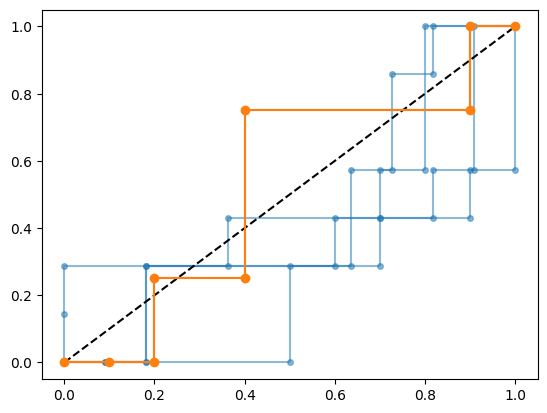

In [344]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt


kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

_auc = []
_tpr = []
_fpr = []

for inds_train, inds_test in kfolds.split(X, y):
    
    # Split
    X_train, y_train = X[inds_train], y[inds_train]
    X_test, y_test = X[inds_test], y[inds_test]

    # Impute
    imp_train = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imp_train.fit_transform(X_train)
    
    imp_test = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_test = imp_test.fit_transform(X_test)
    
    # Scale
    scaler_train = StandardScaler()
    X_train = scaler_train.fit_transform(X_train)
    
    scaler_test = StandardScaler()
    X_test = scaler_test.fit_transform(X_test)
    
    # Outlier removal
#     isofor = IsolationForest(n_estimators=500)
#     isofor.fit(X_train)
    
#     inliers = isofor.predict(X_train) == 1
    
#     X_train = X_train[inliers]
#     y_train = y_train[inliers]
    
    
#     isofor = IsolationForest(n_estimators=500)
#     isofor.fit(X_test)
    
#     inliers = isofor.predict(X_test) == 1
    
#     X_test = X_test[inliers]
#     y_test = y_test[inliers]
    
    # Model   
    #lr = SGDClassifier(loss="log_loss", penalty="elasticnet")
    
    lr = LogisticRegression(penalty="l1", solver="liblinear")    
    #lr = LogisticRegression()
    #lr = SVC(probability=True)
    
    # Grid search
    # params = {'alpha': np.linspace(1e-2, 1e1, 1000), "l1_ratio": np.linspace(.01, .99, 1000)}
    # lr = RandomizedSearchCV(lr, params, n_iter=200, random_state=0)
    
    # Train
    lr.fit(X_train, y_train)
        
    # Test
    fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1], pos_label=1)
    
    print(auc(fpr, tpr).round(2))
    plt.plot(fpr, tpr, "-o", color='C0', ms=4, alpha=.5)
    
    _auc.append(auc(fpr, tpr))
    _tpr.append(tpr)
    _fpr.append(fpr)
     
plt.plot([0, 1], [0, 1], color='k', ls='--')

print()
print(np.mean(_auc).round(2))


plt.plot(_fpr[np.argmax(_auc)], _tpr[np.argmax(_auc)], "-o", color='C1');

In [348]:
lr.predict(X_train) == y_train

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

0.58
0.44
0.88
0.98
0.67

0.71


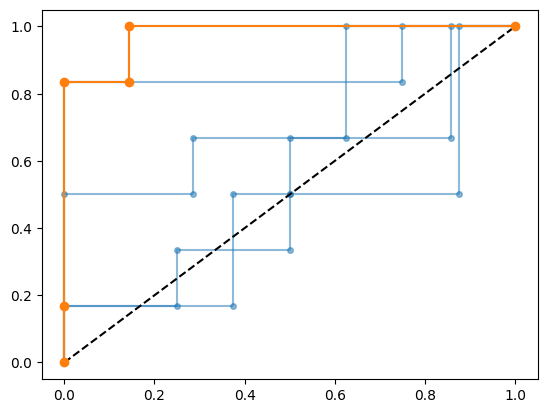

In [290]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt


kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

_auc = []
_tpr = []
_fpr = []

for inds_train, inds_test in kfolds.split(X, y):
    
    # Split
    X_train, y_train = X[inds_train], y[inds_train]
    X_test, y_test = X[inds_test], y[inds_test]

    # Impute
    imp_train = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imp_train.fit_transform(X_train)
    
    imp_test = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_test = imp_test.fit_transform(X_test)
    
    # Scale
    scaler_train = StandardScaler()
    X_train = scaler_train.fit_transform(X_train)
    
    scaler_test = StandardScaler()
    X_test = scaler_test.fit_transform(X_test)
    
    # Outlier removal
    contam = .2
    isofor = IsolationForest(n_estimators=500, contamination=contam)
    isofor.fit(X_train)
    
    inliers = isofor.predict(X_train) == 1
    
    X_train = X_train[inliers]
    y_train = y_train[inliers]
    
    
    isofor = IsolationForest(n_estimators=500, contamination=contam)
    isofor.fit(X_test)
    
    inliers = isofor.predict(X_test) == 1
    
    X_test = X_test[inliers]
    y_test = y_test[inliers]
    
    # Model   
    #lr = SGDClassifier(loss="log_loss", penalty="elasticnet")
    
    #lr = LogisticRegression(penalty="l1", solver="liblinear")    
    
    lr = SVC(probability=True)
    
    # Grid search
    #params = {'alpha': np.linspace(1e-2, 1e1, 1000), "l1_ratio": np.linspace(.01, .99, 1000)}
    #lr = RandomizedSearchCV(lr, params, n_iter=200, random_state=0)
    
    # Train
    lr.fit(X_train, y_train)
        
    # Test
    fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1], pos_label=1)
    
    print(auc(fpr, tpr).round(2))
    plt.plot(fpr, tpr, "-o", color='C0', ms=4, alpha=.5)
    
    _auc.append(auc(fpr, tpr))
    _tpr.append(tpr)
    _fpr.append(fpr)
     
plt.plot([0, 1], [0, 1], color='k', ls='--')

print()
print(np.mean(_auc).round(2))


plt.plot(_fpr[np.argmax(_auc)], _tpr[np.argmax(_auc)], "-o", color='C1');

In [ ]:
# Load features
df = pd.read_csv("alzheimers_features.csv")

# Load correlation features
corr = np.load("corr_params.npy")
corr_var_names = np.load("corr_params_names.npy")
df_corr = pd.DataFrame(corr, columns=corr_var_names)

# Merge dfs
df = pd.concat([df, df_corr], axis=1)

# X and y
X = df.iloc[:, 1:].to_numpy()

y = np.zeros(len(X), dtype=int)
y[df["label"] == 'A'] = 1 # alzheimer's
y[df["label"] == 'C'] = 0 # controls

# Scaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Impute missing values
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# X = imp.fit_transform(X)


# Add intercept
variable_names = list(df.columns[1:])



# Drop offset, constant, and exponent parameters
#   for faster computation
keep = []

for i, v in enumerate(variable_names):
    if ("offset" not in v) and ("const" not in v) and ("exp" not in v):
        keep.append(i)

X = X[:, keep]
variable_names = np.array(variable_names)[keep].tolist()
variable_names.insert(0, "(Intercept)")


In [ ]:

# RiskSLIM settings
settings = {
    "max_runtime": 60.0,
    "max_tolerance": np.finfo("float").eps,
    "loss_computation": "fast",
    "round_flag": True,
    "polish_flag": True,
    "chained_updates_flag": True,
    "add_cuts_at_heuristic_solutions": True,
    "initialization_flag": True,
    "init_max_runtime": 60.0,
    "init_max_coefficient_gap": 0.9,
    "cplex_randomseed": 0,
    "cplex_mipemphasis": 0,
}




kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

_auc = []
_tpr = []
_fpr = []

for inds_train, inds_test in kfolds.split(X, y):
    
    # Split
    X_train, y_train = X[inds_train], y[inds_train]
    X_test, y_test = X[inds_test], y[inds_test]

    # Impute
    imp_train = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imp_train.fit_transform(X_train)
    
    imp_test = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_test = imp_test.fit_transform(X_test)
    
    # Scaler
    scaler_train = StandardScaler()
    X_train = scaler_train.fit_transform(X_train)
    
    scaler_test = StandardScaler()
    X_test = scaler_test.fit_transform(X_test)
    

    X_train = np.insert(X_train, 0, np.ones(len(X_train)), axis=1)
    X_test = np.insert(X_test, 0, np.ones(len(X_test)), axis=1)
    
    # Model   
    rs = RiskSLIMClassifier(
        max_size=10, 
        max_coef=20,
        max_abs_offset=20,
        variable_names=variable_names,
        outcome_name="alzheimers",
        verbose=False,
        settings=settings
    )

    # Train
    rs.fit(X_train, y_train)
        
    # Test
    fpr, tpr, thresholds = roc_curve(y_test, rs.predict_proba(X_test), pos_label=1)
    print(auc(tpr, fpr).round(2))
    print(np.array(variable_names)[rs.rho != 0])
    print()
    plt.plot(tpr, fpr, "-o", color='C0', ms=4, alpha=.5)
    _auc.append(auc(tpr, fpr))
    _tpr.append(tpr)
    _fpr.append(fpr)
     
plt.plot([0, 1], [0, 1], color='k', ls='--')

print()
print(np.mean(_auc).round(2))


plt.plot(_tpr[np.argmax(_auc)], _fpr[np.argmax(_auc)], "-o", color='C1');

0.54
0.51
0.51
0.33
0.46

0.47


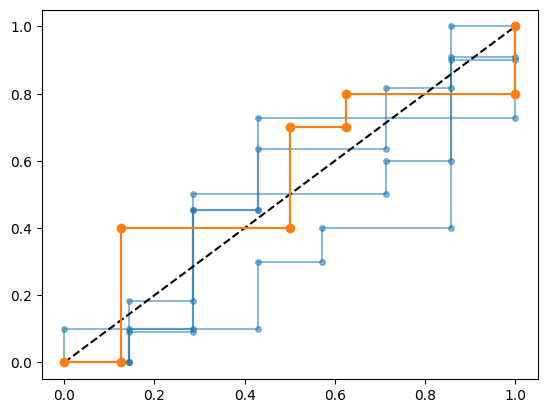

In [20]:
variable_names

['(Intercept)',
 'linear_slope_Fp1',
 'alpha_knee_freq_Fp1',
 'alpha_exp_Fp1',
 'gamma_knee_freq_Fp1',
 'gamma_exp_Fp1',
 'linear_slope_Fp2',
 'alpha_knee_freq_Fp2',
 'alpha_exp_Fp2',
 'gamma_knee_freq_Fp2',
 'gamma_exp_Fp2',
 'linear_slope_F3',
 'alpha_knee_freq_F3',
 'alpha_exp_F3',
 'gamma_knee_freq_F3',
 'gamma_exp_F3',
 'linear_slope_F4',
 'alpha_knee_freq_F4',
 'alpha_exp_F4',
 'gamma_knee_freq_F4',
 'gamma_exp_F4',
 'linear_slope_C3',
 'alpha_knee_freq_C3',
 'alpha_exp_C3',
 'gamma_knee_freq_C3',
 'gamma_exp_C3',
 'linear_slope_C4',
 'alpha_knee_freq_C4',
 'alpha_exp_C4',
 'gamma_knee_freq_C4',
 'gamma_exp_C4',
 'linear_slope_P3',
 'alpha_knee_freq_P3',
 'alpha_exp_P3',
 'gamma_knee_freq_P3',
 'gamma_exp_P3',
 'linear_slope_P4',
 'alpha_knee_freq_P4',
 'alpha_exp_P4',
 'gamma_knee_freq_P4',
 'gamma_exp_P4',
 'linear_slope_O1',
 'alpha_knee_freq_O1',
 'alpha_exp_O1',
 'gamma_knee_freq_O1',
 'gamma_exp_O1',
 'linear_slope_O2',
 'alpha_knee_freq_O2',
 'alpha_exp_O2',
 'gamma_knee_f

 The 'loss' parameter of SGDClassifier must be a str among {'huber', 'squared_hinge', 'log' (deprecated), 'modified_huber', 'epsilon_insensitive', 'squared_epsilon_insensitive', 'perceptron', 'hinge', 'squared_error', 'log_loss'}. Got '' instead.

4

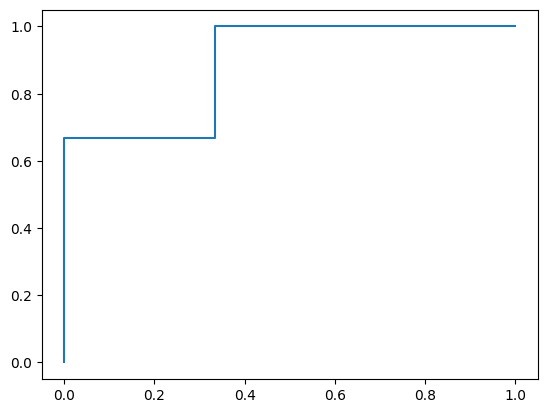

In [148]:
plt.plot(tpr, fpr)

### RiskSLIM

RiskSLIM is a sparse linear integer model with risk scores. This model provides improved interpretablity compared to standard logistic regression.

In [3]:
# RiskSLIM settings
settings = {
    "max_runtime": 30.0,
    "max_tolerance": np.finfo("float").eps,
    "loss_computation": "fast",
    "round_flag": True,
    "polish_flag": True,
    "chained_updates_flag": True,
    "add_cuts_at_heuristic_solutions": True,
    "initialization_flag": True,
    "init_max_runtime": 120.0,
    "init_max_coefficient_gap": 0.9,
    "cplex_randomseed": 0,
    "cplex_mipemphasis": 0,
}

# Initialize model
rs = RiskSLIMClassifier(
    max_size=5, 
    max_coef=6,
    max_abs_offset=10,
    variable_names=variable_names,
    outcome_name="alzheimers",
    verbose=False,
    settings=settings
)

# Fit
rs.fit(X, y)

rs

+------------------------------------------------------+-------------------+-----------+
| Pr(ALZHEIMERS = +1) = 1.0/(1.0 + exp(-(1 + score))   |                   |           |
| ==================================================== | ================= | ========= |
| linear_slope_O1                                      |          5 points |   + ..... |
| alpha_knee_freq_C3                                   |          4 points |   + ..... |
| gamma_knee_freq_F4                                   |         -1 points |   + ..... |
| alpha_knee_freq_Cz                                   |         -2 points |   + ..... |
| linear_slope_Pz                                      |         -5 points |   + ..... |
| ==================================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 5                          |             SCORE |   = ..... |
+------------------------------------------------------+-------------------+-----------+

In [7]:
rs.create_report("report.html")

PosixPath('report.html')

In [12]:
from IPython.display import IFrame

IFrame(src="report.html", width=1200, height=1000)